# Overfitting et surparamétrisation


## 1 Objectifs pédagogiques

Ce TP représente une ouverture sur une piste de recherche actuelle pour comprendre le fonctionnement des réseaux de neurones. Nous allons ici reproduire une expérience numérique du papier suivant et essayer de comprendre ce qu’on peut en tirer. Ce TP a plusieurs ambitions :

- Améliorer la maîtrise du langage PyTorch.

- Explorer de manière critique le concept d’“overfitting”.

- Comprendre le phénomène de double descente et les effets surprenants d’une surparamétrisation.

- Introduire le modèle “random ReLU Feature” (un réseau de neurones simple à une couche).

- Définir une procédure d’entraînement et continuer à explorer la dynamique des algorithmes d’optimisation.

- Comprendre certaines parties du papier de Mikhail Belkin, Fit without fear: remarkable mathematical phenomena of deep learning through the prism of interpolation, Acta Numerica 2021.


## 2 Random ReLU features

Nous allons ici appliquer un réseau de neurone à une couche très simple appelé random ReLU feature.  
Il possède la forme suivante :
\begin{equation}
h(x, w) = \sum_{d=1}^D w_d \phi_d(x) \quad \text{où} \quad \phi_d(x) = \max(x - b_d, 0)
\end{equation}

Nous nous intéresserons à une application en 1D, i.e. où x ∈ R. Ceci permettra de mieux visualiser certains phénomènes, même si les mêmes observations peuvent être reproduites en dimension arbitraire.  
N’hésitez pas à le faire par exemple sur un problème de classification MNIST si ces phénomènes vous surprennent. Dans notre cadre, les vecteurs bd sont tirés indépendamment et uniformément au hasard sur $[−1, 1]$. C’est pour cette raison qu’on emploie le terme “random” feature.

1. Tracez les fonctions $\phi(\cdot)$ pour différentes valeurs de $b_d \in \mathbb{R}$. Est-ce qu’elle vous rappellent une fonction connue en apprentissage profond ?

2. Quelle est la structure de la fonction $h$ ? Comment interpréter les poids $w_k$ ?

3. Pouvez-vous déterminer la structure de la fonction $h$ si $x \in \mathbb{R}^P, P \in \mathbb{N}$ et si $\phi_d(x) = max(\langle x, v_d\rangle − b_d, 0)$, où $v_d$ vit sur la sphère unité ?

## 3 Mise en place sous PyTorch

Dans ce TP, nous allons complètement nous affranchir de numpy. C’est une librairie de calcul pratique et plutôt efficace. Cependant, PyTorch offre des fonctionnalités similaires et plusieurs de ses fonctions sont mieux optimisées. De plus, cette librairie permet de travailler sur GPU ou CPU sans effort.

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim

#%% GPU or CPU ?
use_cuda=torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print("GPU: ", use_cuda)

Nous définissons aussi la fonction $f$ à apprendre sur l’intervalle $[−1, 1]$ dans le code ci-dessous (vous pouvez la modifier si vous le souhaitez).

In [1]:
#%% The function to learn
def f(X):
    return (torch.abs(X)*torch.sin(2*2*torch.pi*X)).type(dtype)

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def phi_d(x,bd):
    return max(x-bd,0)
x=np.linspace(-1,1,100)
plt.plot(x,phi_d(x,1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Préliminaires
1. Tracez la fonction $f$.

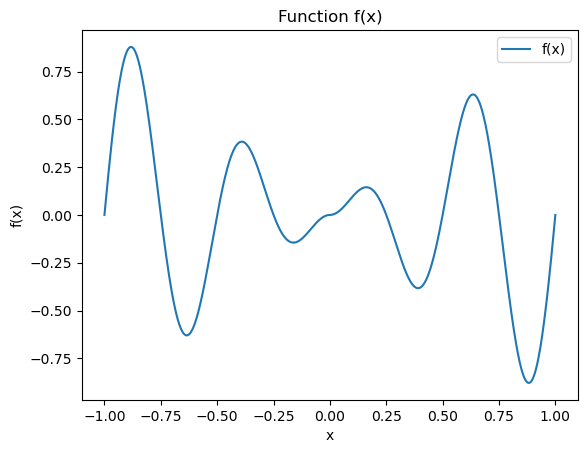

In [3]:
# Generate X values
X_values = torch.linspace(-1, 1, 1000).to(device)  # Transfer to GPU if available
# Calculate corresponding Y values
Y_values = f(X_values)

# Plot the function f
plt.plot(X_values.cpu().numpy(), Y_values.cpu().numpy(), label='f(x)')
plt.title('Function f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

2. Générez un jeu d’apprentissage $(x_n, y_n)$ en échantillonnant la fonction $f$ suivant les positions $x_n = −1 + 2n/N$ où $N$ est le nombre total de mesures d’entraînement et $y_n = f(x_n)$. L’objectif ici va être d’approcher la fonction $f$ à partir des points d’échantillonnage $(x_n, y_n)$.

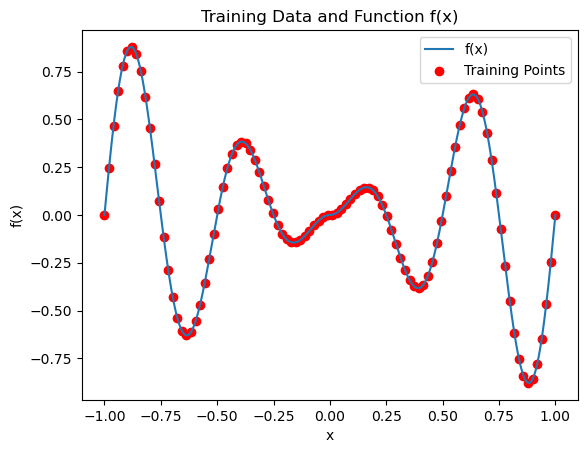

In [4]:
# Number of training samples
N = 100

# Generate training data
X_train = torch.linspace(-1, 1, N).to(device)  # Transfer to GPU if available
Y_train = f(X_train)

# Plot the training data points along with the function f
plt.plot(X_values.cpu().numpy(), Y_values.cpu().numpy(), label='f(x)')
plt.scatter(X_train.cpu().numpy(), Y_train.cpu().numpy(), color='red', label='Training Points')
plt.title('Training Data and Function f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


Considérons le problème d’optimisation du risque empirique suivant :
\begin{equation}
\underset{w \in \mathbb{R}^D}{\text{inf }} R_N(w) \quad \text{avec} \quad R_N(w) = \frac{1}{2N} \sum_{n=1}^N ||h(x_n, w) − y_n||^2_2
\end{equation}

### Un peu de géométrie
1. Déterminez une condition sur les coefficients $b_d$ pour qu’il existe un poids $w$ tel que $R_N(w) = 0$.

On a :  
$h(x_n, w) = \sum_{d=1}^D w_d \phi_d(x_n)$.  

On pose :  
$\psi_n = (\phi_1(x_n), \dots, \phi_D(x_n))$

Donc :  
$h(x_n, w) = \langle w, \psi_n \rangle$

On pose :  
$Y = \begin{pmatrix}
y_1 \\
\vdots \\
y_N
\end{pmatrix} \in \mathbb{R}^N \quad$ et $\quad W = \begin{pmatrix}
w_1 \\
\vdots \\
w_D
\end{pmatrix} \in \mathbb{R}^D$.

Soit $\Psi = \begin{pmatrix}
\psi_1^T \\
\vdots \\
\psi_N^T
\end{pmatrix} \in \mathbb{R}^{N \times D}$.

On a donc :  
$$
R_N(w) = \frac{1}{2N} ||\Psi W - Y||_2^2
$$

On cherche $w$ tel que $R_N(w) = 0$.
\begin{align*}
R_N(w) = 0 &\Leftrightarrow \Psi W = Y \\
&\Leftrightarrow \Psi^T \Psi W = \Psi^T Y \\
&\Leftrightarrow W = (\Psi^T \Psi)^{-1} \Psi^T Y \quad \text{et} \quad \Psi^T \Psi \in \mathbb{R}^{D \times D} \text{ est inversible}
\end{align*}

2. Est-ce que le problème (2) est convexe ? Différentiable ? Est-ce que la solution est unique ?

### Opérations sur les tenseurs 
PyTorch permet de faire des opérations sur des tenseurs de taille différentes. Pour essayer de comprendre ce mécanisme, je vous propose l’expérience suivante :

1. Construisez un tenseur $\texttt{A}$ de taille $3 \times 1$ et un tenseur $\texttt{B}$ de taille $1 \times 4$.

In [5]:
# Construire le tenseur A de taille 3x1
A = torch.tensor([[1], [2], [3]])

# Construire le tenseur B de taille 1x4
B = torch.tensor([[4, 5, 6, 7]])

print("Tenseur A:")
print(A)

print("\nTenseur B:")
print(B)

Tenseur A:
tensor([[1],
        [2],
        [3]])

Tenseur B:
tensor([[4, 5, 6, 7]])


2. Pouvez-vous calculer $\texttt{A + B}$ en PyTorch ? Quelle opération est effectuée ?

In [6]:
# Calculer A + B
C = A + B

print("Résultat de A + B:")
print(C)

Résultat de A + B:
tensor([[ 5,  6,  7,  8],
        [ 6,  7,  8,  9],
        [ 7,  8,  9, 10]])


3. Construisez maintenant un tenseur $\texttt{A}$ de taille $3$ et un tenseur $\texttt{B}$ de taille $4$. Calculez $\texttt{A[:, N one] + B[N one, :]}$. Comprenez comment l’opération est effectuée

In [7]:
# Construire le tenseur A de taille 3
A = torch.tensor([1, 2, 3])

# Construire le tenseur B de taille 4
B = torch.tensor([4, 5, 6, 7])

print("Tenseur A:")
print(A)

print("\nTenseur B:")
print(B)

print("Résultat de A[:, None] + B[None, :]:")
print(A[:, None] + B[None, :])

Tenseur A:
tensor([1, 2, 3])

Tenseur B:
tensor([4, 5, 6, 7])
Résultat de A[:, None] + B[None, :]:
tensor([[ 5,  6,  7,  8],
        [ 6,  7,  8,  9],
        [ 7,  8,  9, 10]])


### Le code principal
Nous sommes prêts à attaquer l’entraînement.

1. Construisez une classe PyTorch définissant le modèle $h$. Il prend la forme suivante, où il faut remplacer les . . . par un bout de code :

In [8]:
class one_layer_NN(nn.Module):
    def __init__(self, n_hidden = 10):
        super(one_layer_NN, self).__init__()
        self.b = 2*(torch.rand(n_hidden)-0.5).to(device)
        self.w = torch.nn.Parameter(torch.zeros(n_hidden)) #nn.parameters allows to define trainable parameters
    def forward(self, x):
        dif = x - self.b[None,None,:]
        hidden = torch.maximum(dif,torch.zeros_like(dif))
        return torch.sum(self.w[None,None,:]*hidden, keepdim=True, dim=2)

2. En prenant exemple sur le TP2, codez un algorithme d’optimisation stochastique pour minimiser le risque empirique sous PyTorch.

In [9]:
from tqdm.auto import tqdm

  0%|          | 0/100000 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (10,) and (1, 10, 1)

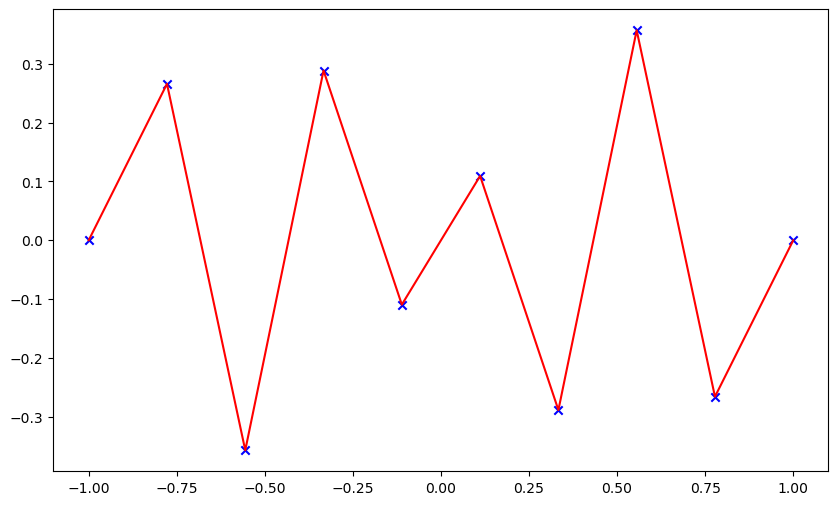

In [10]:
# Parameters
N = 10
n_hidden = 1000 # Defining the model     
learning_rate = 1e-2
batch_size = 10
niter_train = 100000
display_prediction_every = 1000

# Optimizer and model
model = one_layer_NN(n_hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
t = tqdm(range(niter_train))
avg_loss = 0
loss_tracking = []

# Generate training data
x = torch.linspace(-1,1,N).type(dtype)
y = f(x)

for i in t:

    # Step 1: # Met à zéro les gradients de tous les paramètres car a chaque itération, pytorch va les accumuler
    optimizer.zero_grad()

    # Step 2: # Calcul de la prédiction du modèle
    predicted_y = model(x[:, None])

    # Step 3: # Calcul de la loss 
    loss = torch.mean((predicted_y - y) ** 2 )

    # Step 4: # Calcul du gradient de la loss par rapport aux paramètres du modèle
    loss.backward()

    # Step 5: # Mise à jour des paramètres du modèle
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()
    loss_tracking.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
        #Visualisation
            plt.figure(figsize=(10, 6))
            plt.scatter(x.cpu().numpy(), y.cpu().numpy(), color='blue', marker='x', label='$(x^{(n)},y^{(n)})$')
            plt.plot(x.cpu().numpy(), y.cpu().numpy(), color= 'red',label='$y = f(x)$')
            plt.plot(x.cpu().numpy(), predicted_y.cpu().numpy(), color= 'green',label='$y = \hat{f}(x)$')
            plt.title("Training Data Sampled from the Function f(x)")
            plt.xlabel("x_n")
            plt.ylabel("y_n")
            plt.legend()
            plt.grid(True)
            plt.show()

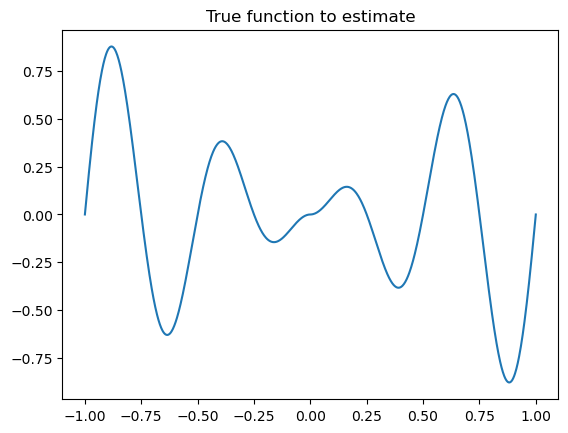

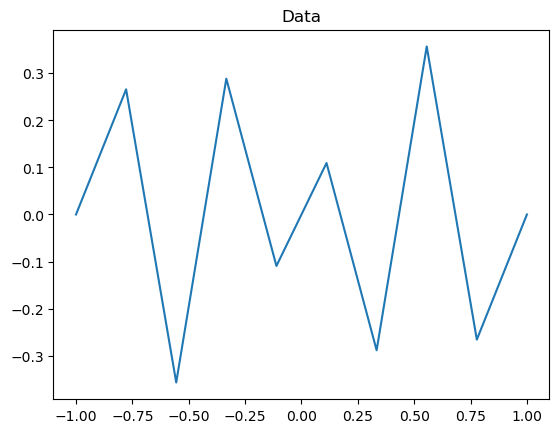

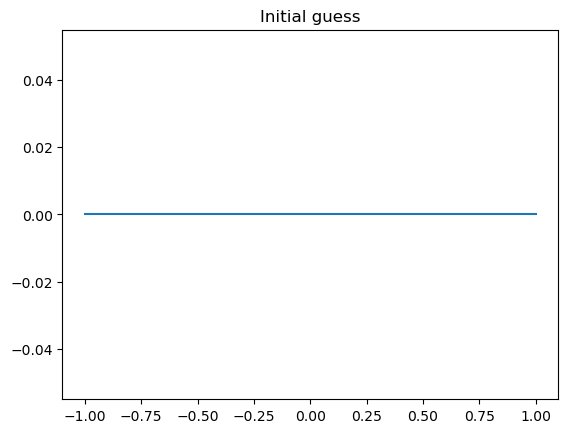

NameError: name 'epochs' is not defined

In [ ]:
# Parameters
N = 10
n_hidden = 1000 # Defining the model     
learning_rate = 1e-2
batch_size = 10
niter_train = 100000

# Generating training data
sigma = 0
M = 1000 # number of sampling points to display the function
T = torch.linspace(-1,1,M).to(device)
fT = f(T) 
plt.figure(1)
plt.plot(T.cpu(),fT.cpu())
plt.title("True function to estimate")
plt.show()

X = torch.linspace(-1,1,N).to(device)
E = sigma * torch.randn_like(X).to(device)
Y = f(X) + E
plt.plot(X.cpu(),Y.cpu())
plt.title("Data")

# Setting up the model
model = one_layer_NN(n_hidden = n_hidden).to(device) 
plt.figure(2)
plt.plot(T.cpu(),model(T[:,None,None])[:,0,0].cpu().detach())
plt.title("Initial guess")
plt.show()

# Create model
model = one_layer_NN(n_hidden=3).to(device)

# Loss function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Generate random training data (replace this with your actual data loading logic)
    X_train = torch.rand(batch_size, 1).to(device)
    Y_train = f(X_train)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)

    # Compute the loss
    loss = criterion(outputs, Y_train)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


3. Prenez soin d’afficher la fonction $h(\cdot, w)$ ainsi que son adéquation aux données tous les $1$, $10$, $100$ ou $1000$ itérations. Ceci permet de vérifier le fonctionnement du code et de trouver un pas (un learning rate) efficace.

## 4 Analyse des résultats
Nous sommes maintenant prêts à analyser les propriétés d’approximation de notre réseau de neurones simpliste.

1. Posez $N = 10$ par exemple (ou une autre valeur assez petite). Affichez les données ainsi que la fonction à retrouver avec MatPlotLib.

2. Calculez la solution de (2) pour $D = 3$, $5$, $10$ (régime sous-paramétré), $D = 15$, $20$, $30$ (régime limite), $D = 50$, $100$, $1000$ (régime sur-paramétré). 

3. Qu’observez vous dans chaque cas ? Pour ce problème, quel est le régime qui fournit les meilleurs résultats qualitatifs ?

4. On va essayer de quantifier cette observation. Pour ce faire, tracez le risque moyen pour différentes valeurs de $D$, e.g. $D \in \{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 70, 90, 100\}$. Décrivez l’allure de la courbe essayez de faire un lien avec une courbe du papier de référence.

## 5 Gradient stochastique et surparamétrisation

Pour finir ce TP, on se propose d’analyser empiriquement le comportement du gradient stochastique dans le régime surparamétré. Da façon informelle, on peut établir le résultat suivant :

> Dans un régime surparamétré, le gradient stochastique à pas constant converge, tandis qu’il ne converge pas sinon.

La raison intuitive derrière cette propriété est que les gradients des fonctions individuelles $f_i$ s’annulent de façon synchrone sur les minimiseurs globaux. C’est un peu comme s’il y avait une réduction de variance automatique.

1. Lancer une descente de gradient stochastique avec un mini-batch pour $D = 5$ et $D = 1000$. Enregister le risque empirique à chaque itération et l’afficher.

2. Est-ce que vous voyez une différence de comportement dans le régime sur-paramétré et dans le régime sous-paramétré ?